In [1]:
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Generate fake data

In [2]:
# Change competitor price (random walk) with probability 5%
def competitor_sim(price_init = 100, N=1000, fixed=False):
    competitor_s = np.zeros(N)
    competitor_s[0] = price_init
    
    if not fixed:
        for i in range(len(competitor_s)-1):
            new_competitor = competitor_s[i]
            if np.random.rand(1)[0] < 0.05:
                new_competitor = new_competitor + (new_competitor/100)*np.random.randn(1)[0]
            competitor_s[i+1] = new_competitor
    else:
        competitor_s = price_init*np.ones(N)
    return competitor_s


# Calculate demand based on demand of the previous days and difference between price and competitor's price
def demand_sim(price, competitor, demand_h):
    demand = 0
    if (price > competitor):
        if np.random.rand(1)[0] < 0.01 and price < 2*competitor:
            demand = np.floor(sum(demand_h)/7)
            if demand == 0:
                demand = 1
    else:
        if np.random.rand(1)[0] < 0.50:
            if np.random.rand(1)[0] < 0.50:
                demand = np.floor(sum(demand_h)/7)
                if demand == 0:
                    demand = 1
            else:
                demand = np.floor(3*sum(demand_h)/7)
                if demand == 0:
                    demand = 1
    return demand

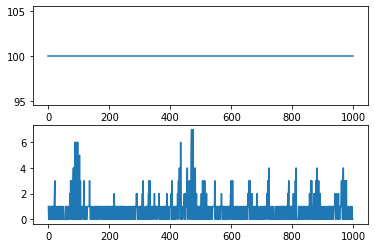

In [3]:
competitor_s = competitor_sim(fixed=True)

demand_s = np.zeros(len(competitor_s))
demand_h = [0 for _ in range(7)]
price = 100

for i in range(len(demand_s)):    
    competitor = competitor_s[i]
    demand = demand_sim(price, competitor, demand_h)
    demand_h.pop()
    demand_h.insert(0, demand)
    demand_s[i] = demand

plt.figure()
plt.subplot(2,1,1)
plt.plot(competitor_s)
plt.subplot(2,1,2)
plt.plot(demand_s)

## Environment

In [4]:
class Environment1:
    
    def __init__(self, competitor_s, demand_t=7, competitor_t=7, cost=80, price_init=100):
        self.competitor_s = competitor_s
        self.N = len(self.competitor_s)
        self.demand_t = demand_t
        self.competitor_t = competitor_t
        self.cost = cost        
        self.price_init = price_init
        
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.demand_h = [0 for _ in range(self.demand_t)]
        self.competitor_h = [0 for _ in range(self.competitor_t)]
        self.price = self.price_init
        self.profits = 0
        return [self.price, self.cost] + self.demand_h + self.competitor_h # obs
    
    def step(self, act):       
        
        # act = 0: stay, 1: raise, 2: lower
        if act == 1:
            self.price = self.price * 1.05
        elif act == 2: # lower
            self.price = self.price * 0.95

        # Change competitor price
        self.competitor_h.pop()
        self.competitor_h.insert(0, competitor_s[self.t])
        
        # Calculate demand
        demand = demand_sim(self.price, self.competitor_h[0], self.demand_h)        
        self.demand_h.pop()
        self.demand_h.insert(0, demand)
        
        reward = (self.price - self.cost)*self.demand_h[0]
        self.profits += reward
        
#         # Clip rewards
#         if reward > 0:
#             reward = 1
#         elif reward < 0:
#             reward = -1
        
        # set next time
        self.t += 1
        
        if (self.t == self.N):
            self.done=True

        return [self.price, self.cost] + self.demand_h + self.competitor_h, reward, self.done # obs, reward, done      
    

In [5]:
env1 = Environment1(competitor_s)

In [6]:
env1.reset()

[100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [7]:
env1.step(2)

([95.0, 80, 1, 0, 0, 0, 0, 0, 0, 100.0, 0, 0, 0, 0, 0, 0], 15.0, False)

In [8]:
env = Environment1(competitor_s)
env.reset()

[100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## NN architecture

In [9]:
#def train_dqn(env):
    
class Q_Network(nn.Module):
        
    def __init__(self,obs_len,hidden_size,actions_n):
            
        super(Q_Network,self).__init__()
            
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
        
        
    def forward(self,x):
        h =  self.fc_val(x)
        return (h)
            

## Parameters

In [10]:
hidden_size = 100
input_size = env.demand_t + env.competitor_t + 2
output_size=3
LR = 0.001

epoch_num = 50
step_max = len(env.competitor_s) - 1
memory_size = 200
batch_size = 50
gamma = 0.97

epsilon = 1.0
epsilon_decrease = 1e-3
epsilon_min = 0.1
start_reduce_epsilon = 200
train_freq = 10
update_q_freq = 20
show_log_freq = 5

## Training

In [11]:
memory = []
total_step = 0
total_rewards = []
total_losses = []

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Q = Q_Network(input_size, hidden_size, output_size).to(device=device)

Q_ast = copy.deepcopy(Q)

loss_function = nn.MSELoss()
optimizer = optim.Adam(list(Q.parameters()), lr=LR)

start = time.time()
for epoch in range(epoch_num):

    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0

    while not done and step < step_max:

        # select act
        pact = np.random.randint(3)
        if np.random.rand() > epsilon:
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)).to(device=device))
            pact = np.argmax(pact.data.cpu())
            pact = pact.numpy()

        # act
        obs, reward, done = env.step(pact)

        # add memory
        memory.append((pobs, pact, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                    q = Q(torch.from_numpy(b_pobs).to(device=device))
                    q_ = Q_ast(torch.from_numpy(b_obs).to(device=device))
                    maxq = np.max(q_.data.cpu().numpy(), axis=1)
                    target = copy.deepcopy(q.data)
                    #import pdb; pdb.set_trace()

                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                    Q.zero_grad()
                    loss = loss_function(q, target)
                    total_loss += loss.data.item()
                    loss.backward()
                    optimizer.step()
                    
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)
                
            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        #if (epoch+1) % show_log_freq == 0:
        if done or step == step_max:  
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
#return Q, total_losses, total_rewards

1	0.39999999999999947	801	226.4573910606302	3132702.3063918115	1.6382555961608887
2	0.0999999999999992	1800	12.0	6.543991373362021e+22	2.0197908878326416
3	0.0999999999999992	2799	51.425965692929466	nan	2.086076259613037
4	0.0999999999999992	3798	758.2642266287583	nan	2.075690746307373
5	0.0999999999999992	4797	726440.2013090309	nan	2.0727627277374268


KeyboardInterrupt: 

In [ ]:
plt.plot(total_rewards[-30000:])

## Testing

In [ ]:
test_env = Environment1(competitor_s)
test_acts=[]
test_rewards = []
pobs = test_env.reset()

done = False
while not done:
    pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)).to(device=device))
    pact = np.argmax(pact.data.cpu())
    test_acts.append(pact.item())
    
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)
    pobs = obs

test_profits = test_env.profits

In [ ]:
plt.plot(test_rewards)

In [ ]:
test_profits